# DMFT calculation with IPT
Author: [XXXX](mailto:XXXX)

## Theory


### Self-consistent equation
We will perform the Dynamical-Mean-Field-Theory(DMFT) on the electron system defined by the semi-circular density of state
$$
    \rho(\omega) = \frac{\sqrt{4-\omega^2}}{2\pi}.
$$
The self-consistent equations we need to solve are
$$
    G_{\mathrm{loc}}(\mathrm{i}\omega_n) = \int d\omega \frac{\rho(\omega)}{\mathrm{i}\omega_n-\omega-\Sigma(\mathrm{i}\omega_n)}, 
$$
$$
    \mathcal{G}^{-1}(\mathrm{i}\omega_n) = G_{\mathrm{loc}}^{-1}(\mathrm{i}\omega_n) + \Sigma(\mathrm{i}\omega_n),
$$
$$
    \Sigma(\tau) = U^2\mathcal{G}^2(\tau)\mathcal{G}(\beta-\tau).
$$
$G_{\mathrm{loc}}$ is the local Green function.$\omega_n$ is the Matsubara frequency of the fermion.$\Sigma$ is the self-energy excluding the hartree-term.$\mathcal{G}$ is the cavity Green function.$U$ is the onsite-Coulomb interaction.$\tau$ is the imaginary time.$\beta$ is the inverse temperature.

### Renormalization factors

$$
z = \frac{1}{1-\frac{\partial \Sigma}{\partial \omega}}
$$

Because a self-energy $\Sigma$ contains an effect of an on-site interaction $U$, then $z$ meets

$$
z\approx1 \ (U\ll1).
$$

## Implmementation

In [1]:
using OMEinsum
using FastGaussQuadrature
using SparseIR
using LaTeXStrings
using Plots

### Non-interacting DOS

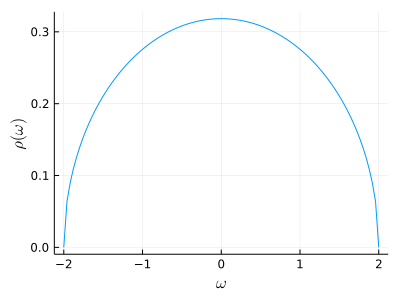

In [2]:
"""
Compute spectral function rho(omega)
"""
rho_omega(omega::Float64) = sqrt(4 - omega^2) / (2*pi)

num_omega = 100
omegas = collect(range(-2, 2, length=num_omega))
rho = rho_omega.(omegas)
p = plot(xlabel="\$\\omega\$", ylabel = "\$\\rho(\\omega)\$", size=(400,300))
plot!(omegas, rho, label=nothing)

### Self-consistent equation

In [3]:
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end
;

In [4]:
"""
Solver
"""
struct IPTSolver
    U::Float64
    basis::FiniteTempBasis{LogisticKernel{Float64}, Float64}
    beta::Float64
    rho_omega::Function
    omega_range::Tuple{Float64,Float64}
    quad_rule::Tuple{Vector{Float64}, Vector{Float64}}
    smpl_matsu::MatsubaraSampling{Int64, FiniteTempBasis{LogisticKernel{Float64}, Float64}, ComplexF64, Float64}
    smpl_tau::TauSampling{Float64, FiniteTempBasis{LogisticKernel{Float64}, Float64}, Float64, Float64}

    function IPTSolver(U::Float64, basis, rho::Function,
        omega_range::Tuple{Float64,Float64}, deg_leggaus::Int64=100)

        quad_rule = _gausslegendre(deg_leggaus, omega_range...)
        smpl_matsu = MatsubaraSampling(basis)
        smpl_tau = TauSampling(basis)

        new(U, basis, SparseIR.getbeta(basis), rho_omega, omega_range, quad_rule, smpl_matsu, smpl_tau)
    end
end
;

In [5]:
""" Solve Dyason equation: Compute G_loc(iv) from Sigma_iv """
function compute_gloc_iv(solver::IPTSolver, sigma_iv::Vector{Complex{Float64}})
    iv = 1im .* solver.smpl_matsu.sampling_points .* π / solver.beta
    newaxis = [CartesianIndex()]
    gloc_iv = ein"q,q,wq->w"(
            solver.quad_rule[2],
            solver.rho_omega.(solver.quad_rule[1]),
            1 ./ ((iv .- sigma_iv)[:, newaxis] .- solver.quad_rule[1][newaxis, :])
        )
    return gloc_iv
end

""" Compute IPT Sigma(iv) from mathcal{G}(iv)"""
function compute_sigma_iv(solver::IPTSolver, g0_iv::Vector{ComplexF64})
    g0_IR = fit(solver.smpl_matsu, g0_iv, dim=1)
    g0_tau = evaluate(solver.smpl_tau, g0_IR)
    sigma_tau = (solver.U)^2 .* (g0_tau).^2 .* g0_tau[end:-1:1]
    sigma_IR = fit(solver.smpl_tau, sigma_tau)
    return evaluate(solver.smpl_matsu, sigma_IR, dim=1)
end

""" Perform one self-consistent loop """
function onestep(solver::IPTSolver, sigma_iv::Vector{Complex{Float64}})
    gloc_iv = compute_gloc_iv(solver, sigma_iv)
    g0_iv = 1 ./ ((1 ./gloc_iv) .+ sigma_iv) 
    return compute_sigma_iv(solver, g0_iv)
end
;

### Computation of renormalization factors

In [8]:
function renormalization_factor(solver::IPTSolver, sigma_iv0::Union{Nothing,Vector{ComplexF64}}, nitr::Int, mixing::Float64)
    # Initialize sigma_iv
    if isnothing(sigma_iv0)
        sigma_iv = zeros(ComplexF64,length(solver.smpl_matsu.sampling_points))
    else
        sigma_iv = copy(sigma_iv0)
    end

    # mixing sigma_iv with new_sigma_iv
    for i in 1:nitr
        new_sigma_iv = onestep(solver,sigma_iv)
        rdiff = maximum(abs.(new_sigma_iv .- sigma_iv)) / maximum(abs.(sigma_iv))
        if rdiff < 1e-5
            break
        end
        sigma_iv = mixing .* new_sigma_iv .+ (1-mixing) .* sigma_iv
    end

    center = Int(length(sigma_iv)/2) + 1 # julia 
    delta_sigma_iv = imag(sigma_iv[center]-sigma_iv[center-1])
    delta_sampling_points = solver.smpl_matsu.sampling_points[center] - solver.smpl_matsu.sampling_points[center-1] 
    inv_z = 1 - delta_sigma_iv/delta_sampling_points

    return 1/inv_z, sigma_iv
end
;


In [12]:
function sweepU(basis::FiniteTempBasis{LogisticKernel{Float64}, Float64}, D::Float64, U_range::Vector{Float64}, rho_omega::Function, omega_range::Tuple{Float64, Float64}, nitr::Int, mixing::Float64)
    Z = Float64[]
    sigma_history = []
    for iu in U_range
        solver = IPTSolver(iu, basis, rho_omega, omega_range)
        sigma_iv0 = length(sigma_history) > 0 ? sigma_history[end] : nothing
        z, sigma_ = renormalization_factor(solver, sigma_iv0, nitr, mixing)
        push!(sigma_history, sigma_)
        if abs(z) > 1e-10
            push!(Z, z)
        else
            break
        end
    end

    return Z, sigma_history
end

# Setup parameters
D = 2.0
temp = 0.1 / D
beta = 1 / temp
wmax = 10.0 * D
lambda = beta * wmax
eps = 1e-7
wmax = lambda / beta
basis = FiniteTempBasis(fermion, beta, wmax, eps)

# Perform a sweep by increasing U
num_U = 20
U_min = 5 / D
U_max = 6.5 / D
U_range = 2 .* collect(range(U_min, U_max, num_U))
omega_range = (-2.0, 2.0)
nitr = 1000
mixing = 0.1
Z, sigma_history = sweepU(basis, D, U_range, rho_omega, omega_range, nitr, mixing);

### Visualization

In [13]:
# PLOT Sigma(iv) at two typical parameters!

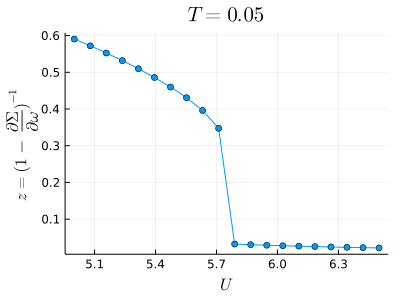

In [10]:
p = plot(xlabel="\$U\$", ylabel = "\$z=(1-\\frac{\\partial \\Sigma}{\\partial \\omega})^{-1}\$",
        title=latexstring("T=0.05"), size=(400,300))
plot!(U_range, Z, marker=:circle, label=nothing)
